# 4.7 - Transposed convolutions

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [327]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard
from time import time
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.4.0'

## Types of convolutions

See [Types of convolutions](https://medium.com/hitchhikers-guide-to-deep-learning/10-introduction-to-deep-learning-with-computer-vision-types-of-convolutions-atrous-convolutions-3cf142f77bc0) for a global view of how convolutions can be made in different ways.

Complementary refs:

- [Up-sampling with Transposed Convolution](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0)
- [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)
- [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)


## Architectures:

- UNet: [https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)
- DeepLab: [https://developers.arcgis.com/python/guide/how-deeplabv3-works/](https://developers.arcgis.com/python/guide/how-deeplabv3-works/)
- Mask R-CNN: [https://towardsdatascience.com/computer-vision-instance-segmentation-with-mask-r-cnn-7983502fcad1](https://towardsdatascience.com/computer-vision-instance-segmentation-with-mask-r-cnn-7983502fcad1)

## Convolution matrix

we have the following (very small) image and filter

In [328]:
simg = np.r_[[[4,5,8,7],[1,8,8,8],[3,6,6,4],[6,5,7,8]]].astype(np.float32)
akernel = np.r_[[[10,-4,10],[10,4-4,30],[30,30,-1]]]
print ("image\n", simg)
print ("--\nfilter\n", akernel)

image
 [[4. 5. 8. 7.]
 [1. 8. 8. 8.]
 [3. 6. 6. 4.]
 [6. 5. 7. 8.]]
--
filter
 [[10 -4 10]
 [10  0 30]
 [30 30 -1]]


and a VALID convolution (with TF and by hand)

In [329]:
c1 = tf.keras.layers.Conv2D(filters=1, kernel_size=akernel.shape, padding="VALID", activation="linear")
c1.build(input_shape=[None, *simg[:,:,None].shape])
c1.set_weights([akernel[:,:,None, None], np.r_[0]])

routput = c1(simg[None, :, :, None]).numpy()
print(routput[0,:,:,0])

[[614. 764.]
 [591. 660.]]


In [330]:
np.r_[[[(simg[:3,:3]*akernel).sum(), (simg[:3,1:]*akernel).sum()],\
       [(simg[1:,:3]*akernel).sum(), (simg[1:,1:]*akernel).sum()]]]

array([[614., 764.],
       [591., 660.]])

observe we can arrange the filter into a **convolutional matrix**, so that a `.dot` operation gets the same result.


$$a_m = c_m \times img$$

with 

- $am \in \mathbb{R}^{4}$, that can be reshaped into $\mathbb{R}^{2\times 2}$
- $cm \in \mathbb{R}^{4\times 16}$
- $img \in \mathbb{R}^{16}$, reshaped from $\mathbb{R}^{4\times 4}$


In [331]:
cm = np.array([[10., -4., 10.,  0., 10.,  0., 30.,  0., 30., 30., -1.,  0.,  0., 0.,  0.,   0.],
               [ 0., 10., -4., 10.,  0., 10.,  0., 30.,  0., 30., 30., -1.,  0., 0.,  0.,   0.],
               [ 0.,  0.,  0.,  0., 10., -4., 10.,  0., 10.,  0., 30.,  0., 30., 30., -1.,  0.],
               [ 0.,  0.,  0.,  0.,  0., 10., -4., 10.,  0., 10.,  0., 30.,  0., 30., 30., -1.]])

dx, dy = np.r_[simg.shape[0] - akernel.shape[0]+1, simg.shape[1] - akernel.shape[1]+1]
am = cm.dot(simg.flatten()).reshape(dx,dy)
am

array([[614., 764.],
       [591., 660.]])

observe that `cm` is just the same `akernel` replicated and re-arranged

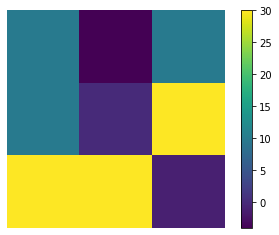

In [332]:
plt.imshow(akernel); plt.axis("off")
plt.colorbar();

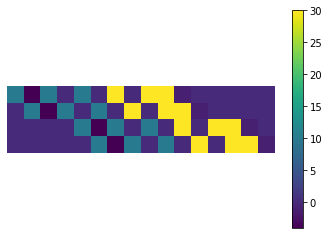

In [333]:
plt.imshow(cm); plt.axis("off")
plt.colorbar();

## Transposed convolutions

we can turn the `.dot` product around by using `cm`´s transpose matrix. This **IS NOT** in general an inverse operation, but the dimensions are kept and can be used to recover reduced dimensions.

$$img´ = c_m^T \times c_m$$

with 

- $img´ \in \mathbb{R}^{16}$, that can be reshaped from $\mathbb{R}^{4\times 4}$
- $cm \in \mathbb{R}^{16\times 4}$
- $am \in \mathbb{R}^{4}$, reshaped into $\mathbb{R}^{2\times 2}$


In [334]:
cm.T.dot(am.flatten()).reshape(simg.shape)

array([[ 6140.,  5184.,  3084.,  7640.],
       [12050., 11876., 21690., 29520.],
       [24330., 47940., 40036., 19036.],
       [17730., 37530., 19209.,  -660.]])

which is implemented as a [`Conv2DTransposed`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) Keras layer

In [335]:
ct = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=akernel.shape, activation="linear")
ct.build(input_shape=[None, *am[:,:,None].shape])
ct.set_weights((akernel[:,:, None, None], np.r_[0]))
ct(am[None, :, :, None]).numpy()[0,:,:,0]

array([[ 6140.,  5184.,  3084.,  7640.],
       [12050., 11876., 21690., 29520.],
       [24330., 47940., 40036., 19036.],
       [17730., 37530., 19209.,  -660.]], dtype=float32)

observe how a transposed convolution is simply a convolution with a padded and dilated input img

In [336]:
def dilate(simg):
    k = simg.copy()
    for i in range(k.shape[1]-1):
        k = np.insert(k, 1+2*i, values=0, axis=1)
    for i in range(k.shape[0]-1):
        k = np.insert(k, 1+2*i, values=0, axis=0)
    return k

def pad(am, n):
    k = np.append(am,np.zeros((n,am.shape[1])), axis=0)
    k = np.append(k,np.zeros((k.shape[0],n)), axis=1)
    k = np.append(np.zeros((k.shape[0],n)), k, axis=1)
    k = np.append(np.zeros((n, k.shape[1])), k, axis=0)
    return k

In [337]:
dam = pad(am, 2)
dam

array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 614., 764.,   0.,   0.],
       [  0.,   0., 591., 660.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]])

a transposed convolution implemented with a regular convolution

In [338]:
dkernel = akernel[::-1,::-1] # hacking to conform to TF 

c1 = tf.keras.layers.Conv2D(filters=1, kernel_size=dkernel.shape, padding="VALID", activation="linear")
c1.build(input_shape=[None, *simg[:,:,None].shape])
c1.set_weights([dkernel.T[:,:,None, None], np.r_[0]])

routput = c1(dam.T[None, :, :, None]).numpy().T
print(routput[0,:,:,0])

[[ 6140.  5184.  3084.  7640.]
 [12050. 11876. 21690. 29520.]
 [24330. 47940. 40036. 19036.]
 [17730. 37530. 19209.  -660.]]


the same transposed convolution with a `Conv2DTranspose` layer

In [339]:
ct = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=akernel.shape, activation="linear")
ct.build(input_shape=[None, *am[:,:,None].shape])
ct.set_weights((akernel[:,:, None, None], np.r_[0]))
ct(am[None, :, :, None]).numpy()[0,:,:,0]

array([[ 6140.,  5184.,  3084.,  7640.],
       [12050., 11876., 21690., 29520.],
       [24330., 47940., 40036., 19036.],
       [17730., 37530., 19209.,  -660.]], dtype=float32)

now with `stride` (i.e. dilation on the input image)

In [340]:
ct = tf.keras.layers.Conv2DTranspose(filters=1, strides=2, kernel_size=akernel.shape, activation="linear")
ct.build(input_shape=[None, *am[:,:,None].shape])
ct.set_weights((akernel[:,:, None, None], np.r_[0]))
ct(am[None, :, :, None]).numpy()[0,:,:,0]

array([[ 6140., -2456., 13780., -3056.,  7640.],
       [ 6140.,     0., 26060.,     0., 22920.],
       [24330., 16056., 34816., 20280.,  5836.],
       [ 5910.,     0., 24330.,     0., 19800.],
       [17730., 17730., 19209., 19800.,  -660.]], dtype=float32)

In [341]:
ct = tf.keras.layers.Conv2DTranspose(filters=1, dilation_rate=2, kernel_size=akernel.shape, activation="linear")
ct.build(input_shape=[None, *am[:,:,None].shape])
ct.set_weights((akernel[:,:, None, None], np.r_[0]))
ct(am[None, :, :, None]).numpy()[0,:,:,0]

array([[ 6140.,  7640., -2456., -3056.,  6140.,  7640.],
       [ 5910.,  6600., -2364., -2640.,  5910.,  6600.],
       [ 6140.,  7640.,     0.,     0., 18420., 22920.],
       [ 5910.,  6600.,     0.,     0., 17730., 19800.],
       [18420., 22920., 18420., 22920.,  -614.,  -764.],
       [17730., 19800., 17730., 19800.,  -591.,  -660.]], dtype=float32)

which is equivalent to a convolution with dilation on the input image

In [342]:
# the input image with padding and dilation
dam = pad(dilate(am), 2)
dam

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 614.,   0., 764.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 591.,   0., 660.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [343]:
dkernel = akernel[::-1,::-1] # hacking to conform to TF 

c1 = tf.keras.layers.Conv2D(filters=1, kernel_size=dkernel.shape, padding="VALID", activation="linear")
c1.build(input_shape=[None, *simg[:,:,None].shape])
c1.set_weights([dkernel.T[:,:,None, None], np.r_[0]])

routput = c1(dam.T[None, :, :, None]).numpy().T
print(routput[0,:,:,0])

[[ 6140. -2456. 13780. -3056.  7640.]
 [ 6140.     0. 26060.     0. 22920.]
 [24330. 16056. 34816. 20280.  5836.]
 [ 5910.     0. 24330.     0. 19800.]
 [17730. 17730. 19209. 19800.  -660.]]


for curiosity, can we find any $am$ such that $img \approx img'$? Observe how

- we set the values of a convolutional filter for which  `trainable=False`
- we fit the `Conv2DTranspose` parameters so that the output is a similar as possible to the input
- we train with the same input-output values

This is, somehow, like a **convolutional autoencoder**, where we fix the encoder and what to find out the decoder.

In [344]:
def get_model(img_size=4, compile=True):
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(1,(3,3), activation="linear", padding="SAME", trainable=False)(inputs)
    outputs = tf.keras.layers.Conv2DTranspose(1,(3,3), strides=1, activation="linear", padding="SAME")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=outputs)
    if compile:
        model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
    return model

In [345]:
m = get_model()
m.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 4, 4, 1)           10        
_________________________________________________________________
conv2d_transpose_37 (Conv2DT (None, 4, 4, 1)           10        
Total params: 20
Trainable params: 10
Non-trainable params: 10
_________________________________________________________________


In [346]:
m.build(input_shape=[None, *am[:,:,None].shape])
m.layers[1].set_weights((akernel[:,:, None, None], np.r_[0]))

In [347]:
m.fit(simg[None, :,:, None], simg[None, :,:, None], epochs=10000, verbose=False)

observe that the reconstructed image values are somewhat similar to the input image

In [348]:
m(simg[None, :,:, None])[0,:,:,0].numpy()

array([[3.2036772, 3.7963479, 6.2032294, 6.6606402],
       [1.9207318, 7.7766604, 9.257421 , 7.304693 ],
       [3.5610216, 7.463056 , 9.20143  , 4.6204095],
       [3.9210246, 2.9471133, 4.64958  , 6.73765  ]], dtype=float32)

In [349]:
simg

array([[4., 5., 8., 7.],
       [1., 8., 8., 8.],
       [3., 6., 6., 4.],
       [6., 5., 7., 8.]], dtype=float32)

these two filters try to be **convolutional inverses** of each other (this is not a rigorous definition, just an intuition!!)

In [350]:
m.layers[1].get_weights()[0][:,:,0,0]

array([[10., -4., 10.],
       [10.,  0., 30.],
       [30., 30., -1.]], dtype=float32)

In [351]:
m.layers[2].get_weights()[0][:,:,0,0]

array([[ 0.0047086 , -0.00065021, -0.00595336],
       [ 0.0004696 , -0.00192431,  0.01631924],
       [-0.00721471,  0.0180657 , -0.01472471]], dtype=float32)

## Downsampling and upsampling

we use our `mini_cifar`, observe how:

- the following models downsize and then upsize the input.
- input and output shapes of the models are the same
- we set up a loss function to reconstruct the input in the output.
- the reconstruction quality with `modelA` with `n_filters=1` and `n_filters=10`, and with `modelB`.
- the artifacts that reconstruction generates.

In [352]:
import h5py
!wget -nc -q https://s3.amazonaws.com/rlx/mini_cifar.h5
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
x_cifar = x_cifar.mean(axis=3)[:,:,:,None] # observe we convert cifar to grayscale
x_cifar.shape, y_cifar.shape

((1000, 32, 32, 1), (1000,))

model A reduces the activation map dimensions with a `MaxPool2D` layer. It only has one `Conv2D` layer

In [353]:
def get_modelA(img_size=32, compile=True):
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(20,(3,3), activation="tanh", padding="SAME", trainable=False)(inputs)
    layers = tf.keras.layers.MaxPool2D(2)(layers)
    outputs = tf.keras.layers.Conv2DTranspose(1,(3,3), strides=2, activation="tanh", padding="SAME")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=outputs)
    if compile:
        model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
    return model

model B reduces the activation map dimensions with a `stride=2` on the convolutional layer. It also has 2 `Conv2D` layers

In [354]:
def get_modelB(img_size=32, compile=True):
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input_1")
    layers = tf.keras.layers.Conv2D(5,(3,3), activation="tanh", padding="SAME", trainable=False)(inputs)
    layers = tf.keras.layers.Conv2D(15,(3,3), strides=2, activation="sigmoid", padding="SAME", trainable=False)(inputs)
    outputs = tf.keras.layers.Conv2DTranspose(1,(3,3), strides=2, activation="tanh", padding="SAME")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=outputs)
    if compile:
        model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse'])
    return model

observe the different artifacts created in each case

In [355]:
#m = get_modelA()
m = get_modelB()
m.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 16, 16, 15)        150       
_________________________________________________________________
conv2d_transpose_38 (Conv2DT (None, 32, 32, 1)         136       
Total params: 286
Trainable params: 136
Non-trainable params: 150
_________________________________________________________________


In [356]:
m.fit(x_cifar, x_cifar, epochs=20, batch_size=1)

Epoch 1/20
1000/1000 [==============================] - 1s 499us/step - loss: 0.1086 - mse: 0.1086
Epoch 2/20
1000/1000 [==============================] - 0s 484us/step - loss: 0.0557 - mse: 0.0557
Epoch 3/20
1000/1000 [==============================] - 1s 506us/step - loss: 0.0518 - mse: 0.0518
Epoch 4/20
1000/1000 [==============================] - 0s 482us/step - loss: 0.0429 - mse: 0.0429
Epoch 5/20
1000/1000 [==============================] - 0s 493us/step - loss: 0.0367 - mse: 0.0367
Epoch 6/20
1000/1000 [==============================] - 0s 484us/step - loss: 0.0322 - mse: 0.0322
Epoch 7/20
1000/1000 [==============================] - 1s 634us/step - loss: 0.0289 - mse: 0.0289
Epoch 8/20
1000/1000 [==============================] - 1s 558us/step - loss: 0.0249 - mse: 0.0249
Epoch 9/20
1000/1000 [==============================] - 1s 512us/step - loss: 0.0208 - mse: 0.0208
Epoch 10/20
1000/1000 [==============================] - 0s 490us/step - loss: 0.0186 - mse: 0.0186
Epoch 11/

In [357]:
px_cifar = m.predict(x_cifar)

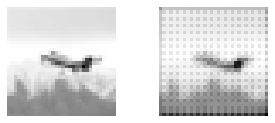

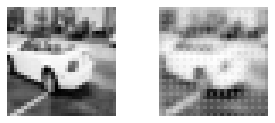

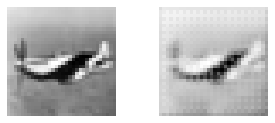

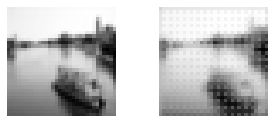

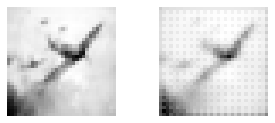

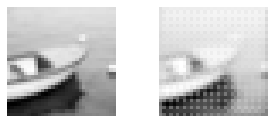

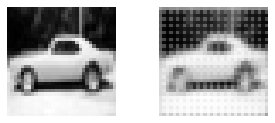

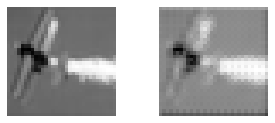

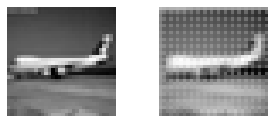

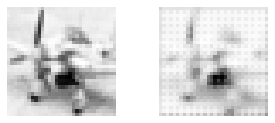

In [358]:
for _ in range(10):
    i = np.random.randint(len(x_cifar))
    plt.figure(figsize=(5,2))
    plt.subplot(121); plt.imshow(x_cifar[i,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off")
    plt.subplot(122); plt.imshow(px_cifar[i,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off")